In [1]:
import os, cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2 
import random
import pickle
import time

from tqdm import tqdm #progress bar
from tensorflow.keras.callbacks import TensorBoard

NAME = "Cats-vs-dogs-CNN"
DATADIR = "PetImages"
CATEGORIES = ["Cat", "Dog"]
IMG_SIZE = (50, 50)

#tensorboard = TensorBoard(log_dir="./PetImages/{}".format(NAME))

In [3]:
dataset = []
for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR, category)  # create path to dogs and cats
    label = CATEGORIES.index(category)
    for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
        try:
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)  # convert to array
            img_array = cv2.resize(img_array, (100, 100))
            dataset.append([img_array, label])            
            #plt.imshow(img_array, cmap='gray')  # graph it
            #plt.show()  # display!
        except:
            pass    

100%|███████████████████████████████████████████████████████████████████████████| 12501/12501 [00:20<00:00, 622.90it/s]


In [4]:
%%time

random.shuffle(dataset)
pickle.dump(dataset, open("pets.pickle", "wb"))

Wall time: 545 ms


In [2]:
dataset = pickle.load(open("pets.pickle", "rb"))

In [3]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize


X = []
y = []
for feature, label in dataset:
    X.append(feature)
    y.append(label)
    
X = np.array(X) / 255
y = np.array(y)

X = X.reshape(-1, 100, 100, 1) #reshape to have 1 level deep
#X = normalize(X, axis = 1)

## Data Prep

In [4]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

In [5]:
import numpy as np
np.sum(y)/len(y), np.sum(y_train)/len(y_train), np.sum(y_valid)/len(y_valid)

(0.49987974023891607, 0.50096215522771, 0.506412997007268)

## Model building

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D

def build_model(n_dense = 1, n_neurons = 64, n_cov = 1, n_cov_size = 64, input_shape = (100, 100, 1)):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(n_cov_size, (3, 3), input_shape = input_shape, activation = "relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    
    for j in range(n_cov - 1):            
        model.add(tf.keras.layers.Conv2D(n_cov_size, (3, 3), activation = "relu"))
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    
    model.add(tf.keras.layers.Flatten())

    for i in range(n_dense):
        model.add(tf.keras.layers.Dense(n_neurons, activation = "relu"))

    model.add(tf.keras.layers.Dense(1, activation = "sigmoid"))
    
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    print(model.summary())
    
    return model

#model = build_model(2, 64, 2, 64, X.shape[1:])

a= """
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape = X.shape[1:], activation="relu")) # the shape of the image not X
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(64, activation = "relu"))
model.add(tf.keras.layers.Dense(1, activation ="sigmoid"))

model.compile(optimizer='adam',
          loss='binary_crossentropy',
          metrics=['accuracy'])
"""

#model.summary()



## Keras Scikit Learn Wrapper

The wrapper wraps around keras model and ensure it behaves like any Scikit learn models (Regressor or Classifiers). 

The default parameters will be used when parameters are not passed.

In [7]:
keras_cnn = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
model_cb = tf.keras.callbacks.ModelCheckpoint("cats_dogs.h5", save_best_only=True)

#keras_cnn.fit(X_train, y_train, 
#          epochs=20, validation_data=(X_valid, y_valid),
#          callbacks=[early_stopping_cb, model_cb], verbose = True)


In [8]:
#keras_cnn.score(X_test, y_test)

#y_pred = keras_cnn.predict(X_test[:3])

## Grid search

In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

#n_dense = 1, n_neurons = 64, n_cov = 1, n_cov_size = 64, input_shape = (100, 100, 1)

param_distribs = {
        "n_dense": [0, 1, 3, 5],
        "n_neurons": [64, 128, 256],
        "n_cov": [1, 3, 5],
        "n_cov_size": [64, 128, 256]
}

search_cv = RandomizedSearchCV(keras_cnn, param_distribs, n_iter=10, cv=3)
search_cv.fit(X_train, y_train, 
          epochs=30, validation_data=(X_valid, y_valid),
          callbacks=[early_stopping_cb, model_cb], verbose = False)


search_cv.best_estimator_.model.save('best.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         1

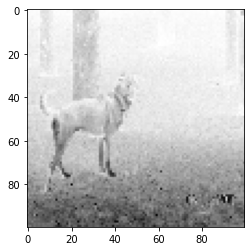

In [10]:
plt.imshow(X_test[1], cmap=plt.cm.binary)

In [13]:
model = search_cv.best_estimator_.model
model.predict(X[:2])

model.evaluate(X_test, y_test)

195/195 [==============================] - 7s 35ms/step - loss: 0.3784 - accuracy: 0.8273


[0.3783840239048004, 0.8273208141326904]

In [23]:
#tf.config.experimental.list_physical_devices('GPU')

[]

In [14]:
search_cv.best_params_

{'n_neurons': 64, 'n_dense': 0, 'n_cov_size': 256, 'n_cov': 5}

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'